In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import lagrange, CubicSpline, PchipInterpolator, interp1d
%config InlineBackend.figure_format = 'retina'

# Ecuación de estado del estado de la materia de las estrellas de neutrones

1. Describir los datos, presión, densidad y densidad de numero:


   * Cuales son las unidades
   * Máximo y mínimos.
   * Paso constante?
   * Cómo responden estas preguntas con python.

2. Realizar las interpolaciones: P y rho; P y nB

   * Lagrange (utilizar 10-20 puntos)
   * Spline cúbico (diferentes condiciones de frontera)
   * PCHIP

3. Comparar graficamente las interpolaciones
4. Crear grupo de entrenamiento y grupo de prueba. Cómo crearon cada grupo.
5. Graficar los errores de cada metodo SE y AE. Calcular MSE y MAE.
6. Cuál es el mejor método?

# Cargar datos

In [2]:
# ====================
# Descargar los datos
# ====================
!wget 'https://drive.google.com/uc?export=download&id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH' -O 'sly4.dat'

--2025-09-18 19:30:17--  https://drive.google.com/uc?export=download&id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH
Resolving drive.google.com (drive.google.com)... 173.194.174.100, 173.194.174.102, 173.194.174.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.174.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH&export=download [following]
--2025-09-18 19:30:17--  https://drive.usercontent.google.com/download?id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.189.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6040 (5.9K) [application/octet-stream]
Saving to: ‘sly4.dat’

sly4.dat            100%[===================>]   5.90K  --.-KB/s    i

In [3]:
#===========================
# Cargar los datos en NumPy
#===========================
data_numpy = np.genfromtxt('./sly4.dat', skip_header=6, usecols=[1,2,3]) # las seis primeras filas las ignoramos, usamos las columnas '2' y '3'
nB = data_numpy[:,0]
rho = data_numpy[:,1]
P = data_numpy[:,2]
print(data_numpy[:5])

#===========================
# Cargar los datos en Pandas
#===========================
cols = ['index', 'n_B[fm^{-3}]', 'rho[g/cm^3]','P[dyn/cm^2]'] # nombres de las columnas
data_pandas = pd.read_csv('sly4.dat', sep='\\s+', skiprows=6, names=cols, usecols=[1,2,3])
data_pandas.head()

[[2.720e-14 4.510e+01 1.700e+14]
 [1.270e-13 2.120e+02 5.820e+15]
 [6.930e-13 1.150e+03 1.900e+17]
 [6.295e-12 1.044e+04 9.744e+18]
 [1.581e-11 2.622e+04 4.968e+19]]


,n_B[fm^{-3}],rho[g/cm^3],P[dyn/cm^2]
0,2.720000e-14,45.1,1.700000e+14
1,1.270000e-13,212.0,5.820000e+15
2,6.930000e-13,1150.0,1.900000e+17
3,6.295000e-12,10440.0,9.744000e+18
4,1.581000e-11,26220.0,4.968000e+19


# 1. Describir los datos, presión, densidad y densidad de numero:

* **Cuales son las unidades**

   * **Densidad numérica bariónica ($n_B$)**: El inverso de femtómetro cúbico ($1/fm^3$).
   * **Densidad de masa ($\rho$)**: Gramos por centímetro cúbico ($g/cm³$).
   * **Presión ($P$)**: Dina por centímetro cuadrado (1 dyn/cm² = 0.1 Pa).

* **Máximo y mínimos**


In [4]:
print("Densidad numérica bariónica (nB)")
print(f"Máximo = {np.max(nB)}")
print(f"Mínimo = {np.min(nB)}")
print()
print("Densidad de masa (ρ):")
print(f"Máximo = {np.max(rho)}")
print(f"Mínimo = {np.min(rho)}")
print()
print("Presión (P)")
print(f"Máximo = {np.max(P)}")
print(f"Mínimo = {np.min(P)}")

Densidad numérica bariónica (nB)
Máximo = 1.997
Mínimo = 2.72e-14

Densidad de masa (ρ):
Máximo = 6749000000000000.0
Mínimo = 45.1

Presión (P)
Máximo = 5.344e+36
Mínimo = 170000000000000.0


* **¿Paso constante?**

  * No, ninguna lista tiene un paso constante

In [5]:
def paso(L):
    Df = L[1::] - L[:-1:]
    for i in range(len(Df)):
        if Df[i] != Df[0]:
            return False
    return True

print(f"nB: {paso(nB)}")
print(f"rho: {paso(rho)}")
print(f"P: {paso(P)}")

nB: False
rho: False
P: False


# Realizar las interpolaciones: P y rho; P y nB

## Presión ($P$) vs. Densidad de masa ($\rho$)

### Definir los puntos de entrenamiento y prueba

---

En esta parte del código, vamos a crear los grupos de entrenamiento y los grupos de prueba. Para las interpolaciones CubicSpline, interp1d y PchipInterpolator elegimos más puntos (p.ej. índices = 101) y los repartimos entre el grupo de prueba y el grupo de entrenamiento, ya que estas funcionan mejor con más puntos. Por otro lado, para la interpolación de Lagrange escogemos no más 6 puntos para el grupo de prueba, ya que Lagrange no es eficiente para muchos datos (explosión de oscilaciones tipo Runge), esta funciona mejor con menos puntos y usamos el mismo grupo de prueba que con los otros.

---


In [6]:
# Para CubicSpline, interp1d y PchipInterpolator
indices11 = np.linspace(0, len(rho)-1, 101, dtype=int) # 101 puntos totales para los grupos de testeo y prueba
Xall1 = rho[indices11]
Yall1 = P[indices11]
Xtrain1 = Xall1[0::2]
Ytrain1 = Yall1[0::2]
Xtest1  = Xall1[1::2]
Ytest1  = Yall1[1::2]

# Para Lagrange
indices12 = np.linspace(0, len(rho)-1, 6, dtype=int) # 6 puntos totales aparte para lagrange
XtrainL1 = rho[indices12]
YtrainL1 = P[indices12]

# Resultados importantes
print(f"Para CubicSpline, interp1d y PchipInterpolator")
print(f"El tamaño del grupo de entrenamiento es de {len(Xtrain1)} puntos")
print(f"El tamaño del grupo de prueba es de {len(Xtest1)} puntos")
print()
print(f"Para Lagrange")
print(f"El tamaño del grupo de entrenamiento es de {len(XtrainL1)} puntos")
print(f"El tamaño del grupo de prueba es de {len(Xtest1)} puntos")

Para CubicSpline, interp1d y PchipInterpolator
El tamaño del grupo de entrenamiento es de 51 puntos
El tamaño del grupo de prueba es de 50 puntos

Para Lagrange
El tamaño del grupo de entrenamiento es de 6 puntos
El tamaño del grupo de prueba es de 50 puntos


### Realizar cada una de las interpolaciones

---

En esta parte del código, vamos a crear nuestras interpolaciones usando los puntos (grupos) de entrenamiento (Xtrain, Ytrain) y los guardamos en una variable simbólica (como una función) que luego evaluaremos para graficar o para calcular los errores.

---


In [48]:
CubicSpline_INT = CubicSpline(Xtrain1, Ytrain1, bc_type = "natural")   # CubicSpline (natural)
interp1d_INT = interp1d(Xtrain1, Ytrain1, kind= "cubic")               # CubicSpline (not-a-knot)
Pchip_INT = PchipInterpolator(Xtrain1, Ytrain1)                        # PchipInterpolator
Lagrange_INT = lagrange(XtrainL1, YtrainL1)                            # lagrange

X1 = np.linspace(Xtrain1[0], Xtrain1[-1],100) # Puntos para las graficas

### Calcular los errores (RAE, MRAE, RSE, MRSE)

---

En esta parte del código, evaluamos los diferentes tipos de errores para comparar la calidad de las interpolaciones:

- **Error Absoluto Relativo (RAE)**  
$$
RAE_i = \frac{|y_i - \hat{y}_i|}{|y_i|}
$$

- **Error Absoluto Relativo Medio (MRAE)**  
$$
MRAE = \frac{1}{n}\sum_{i=1}^n RAE_i
$$

- **Error Cuadrático Relativo (RSE)**  
$$
RSE_i = \left(\frac{|y_i - \hat{y}_i|}{|y_i|}\right)^2
$$

- **Error Cuadrático Relativo Medio (MRSE)**  
$$
MRSE = \frac{1}{n}\sum_{i=1}^n RSE_i
$$

---


In [49]:
# Relative Absolute Error (RAE)
RAE_Lagrange1 = np.abs(Ytest1 - Lagrange_INT(Xtest1)) / np.abs(Ytest1)
RAE_CubicSpline1 = np.abs(Ytest1 - CubicSpline_INT(Xtest1)) / np.abs(Ytest1)
RAE_interp1d1 = np.abs(Ytest1 - interp1d_INT(Xtest1)) / np.abs(Ytest1)
RAE_Pchip1 = np.abs(Ytest1 - Pchip_INT(Xtest1)) / np.abs(Ytest1)

# Mean Relative Absolute Error (MRAE)
MRAE_Lagrange1 = np.mean(RAE_Lagrange1)
MRAE_CubicSpline1 = np.mean(RAE_CubicSpline1)
MRAE_interp1d1 = np.mean(RAE_interp1d1)
MRAE_Pchip1 = np.mean(RAE_Pchip1)

# Relative Squared Error (RSE)
RSE_Lagrange1 = RAE_Lagrange1**2
RSE_CubicSpline1 = RAE_CubicSpline1**2
RSE_interp1d1 = RAE_interp1d1**2
RSE_Pchip1 = RAE_Pchip1**2

# Mean Relative Squared Error (MRSE)
MRSE_Lagrange = np.mean(RSE_Lagrange1)
MRSE_CubicSpline = np.mean(RSE_CubicSpline1)
MRSE_interp1d = np.mean(RSE_interp1d1)
MRSE_Pchip = np.mean(RSE_Pchip1)

In [51]:
print("\n=== Relative Absolute Error (RAE) ===")
print(f"RAE Lagrange       -> Min: {np.min(RAE_Lagrange1):.3e} | Max: {np.max(RAE_Lagrange1):.3e}")
print(f"RAE CS (Natural)   -> Min: {np.min(RAE_CubicSpline1):.3e} | Max: {np.max(RAE_CubicSpline1):.3e}")
print(f"RAE CS (not-a-knot)-> Min: {np.min(RAE_interp1d1):.3e} | Max: {np.max(RAE_interp1d1):.3e}")
print(f"RAE PCHIP          -> Min: {np.min(RAE_Pchip1):.3e} | Max: {np.max(RAE_Pchip1):.3e}")

print("\n=== Mean Relative Absolute Error (MRAE) ===")
print(f"MRAE Lagrange:        {MRAE_Lagrange1:.3e}")
print(f"MRAE CS (Natural):    {MRAE_CubicSpline1:.3e}")
print(f"MRAE CS (not-a-knot): {MRAE_interp1d1:.3e}")
print(f"MRAE PCHIP:           {MRAE_Pchip1:.3e}")

print("\n=== Relative Squared Error (RSE) ===")
print(f"RSE Lagrange       -> Min: {np.min(RSE_Lagrange1):.3e} | Max: {np.max(RSE_Lagrange1):.3e}")
print(f"RSE CS (Natural)   -> Min: {np.min(RSE_CubicSpline1):.3e} | Max: {np.max(RSE_CubicSpline1):.3e}")
print(f"RSE CS (not-a-knot)-> Min: {np.min(RSE_interp1d1):.3e} | Max: {np.max(RSE_interp1d1):.3e}")
print(f"RSE PCHIP          -> Min: {np.min(RSE_Pchip1):.3e} | Max: {np.max(RSE_Pchip1):.3e}")

print("\n=== Mean Relative Squared Error (MRSE) ===")
print(f"MRSE Lagrange:        {MRSE_Lagrange:.3e}")
print(f"MRSE CS (Natural):    {MRSE_CubicSpline:.3e}")
print(f"MRSE CS (not-a-knot): {MRSE_interp1d:.3e}")
print(f"MRSE PCHIP:           {MRSE_Pchip:.3e}")



=== Relative Absolute Error (RAE) ===
RAE Lagrange       -> Min: 1.525e-03 | Max: 2.821e+04
RAE CS (Natural)   -> Min: 1.834e-05 | Max: 2.082e+01
RAE CS (not-a-knot)-> Min: 1.834e-05 | Max: 1.092e+01
RAE PCHIP          -> Min: 1.413e-05 | Max: 1.450e+01

=== Mean Relative Absolute Error (MRAE) ===
MRAE Lagrange:        5.770e+02
MRAE CS (Natural):    4.252e-01
MRAE CS (not-a-knot): 2.263e-01
MRAE PCHIP:           3.005e-01

=== Relative Squared Error (RSE) ===
RSE Lagrange       -> Min: 2.324e-06 | Max: 7.958e+08
RSE CS (Natural)   -> Min: 3.363e-10 | Max: 4.335e+02
RSE CS (not-a-knot)-> Min: 3.363e-10 | Max: 1.192e+02
RSE PCHIP          -> Min: 1.996e-10 | Max: 2.103e+02

=== Mean Relative Squared Error (MRSE) ===
MRSE Lagrange:        1.592e+07
MRSE CS (Natural):    8.670e+00
MRSE CS (not-a-knot): 2.385e+00
MRSE PCHIP:           4.207e+00


### Gráficas

**Gráfica de interpolaciones**

---

En esta parte del codigo se grafican los resultados de las interpolaciones junto con los puntos de entrenamiento y prueba:

- Se diferencian los **conjuntos de datos** (entrenamiento y prueba) mediante colores, formas y tamaños de marcadores.  
- Se muestran las **curvas de interpolación** obtenidas con los distintos métodos: Lagrange, Cubic Spline, interp1d y Pchip.  
- Los ejes incluyen las **unidades físicas** de cada lista de datos

---


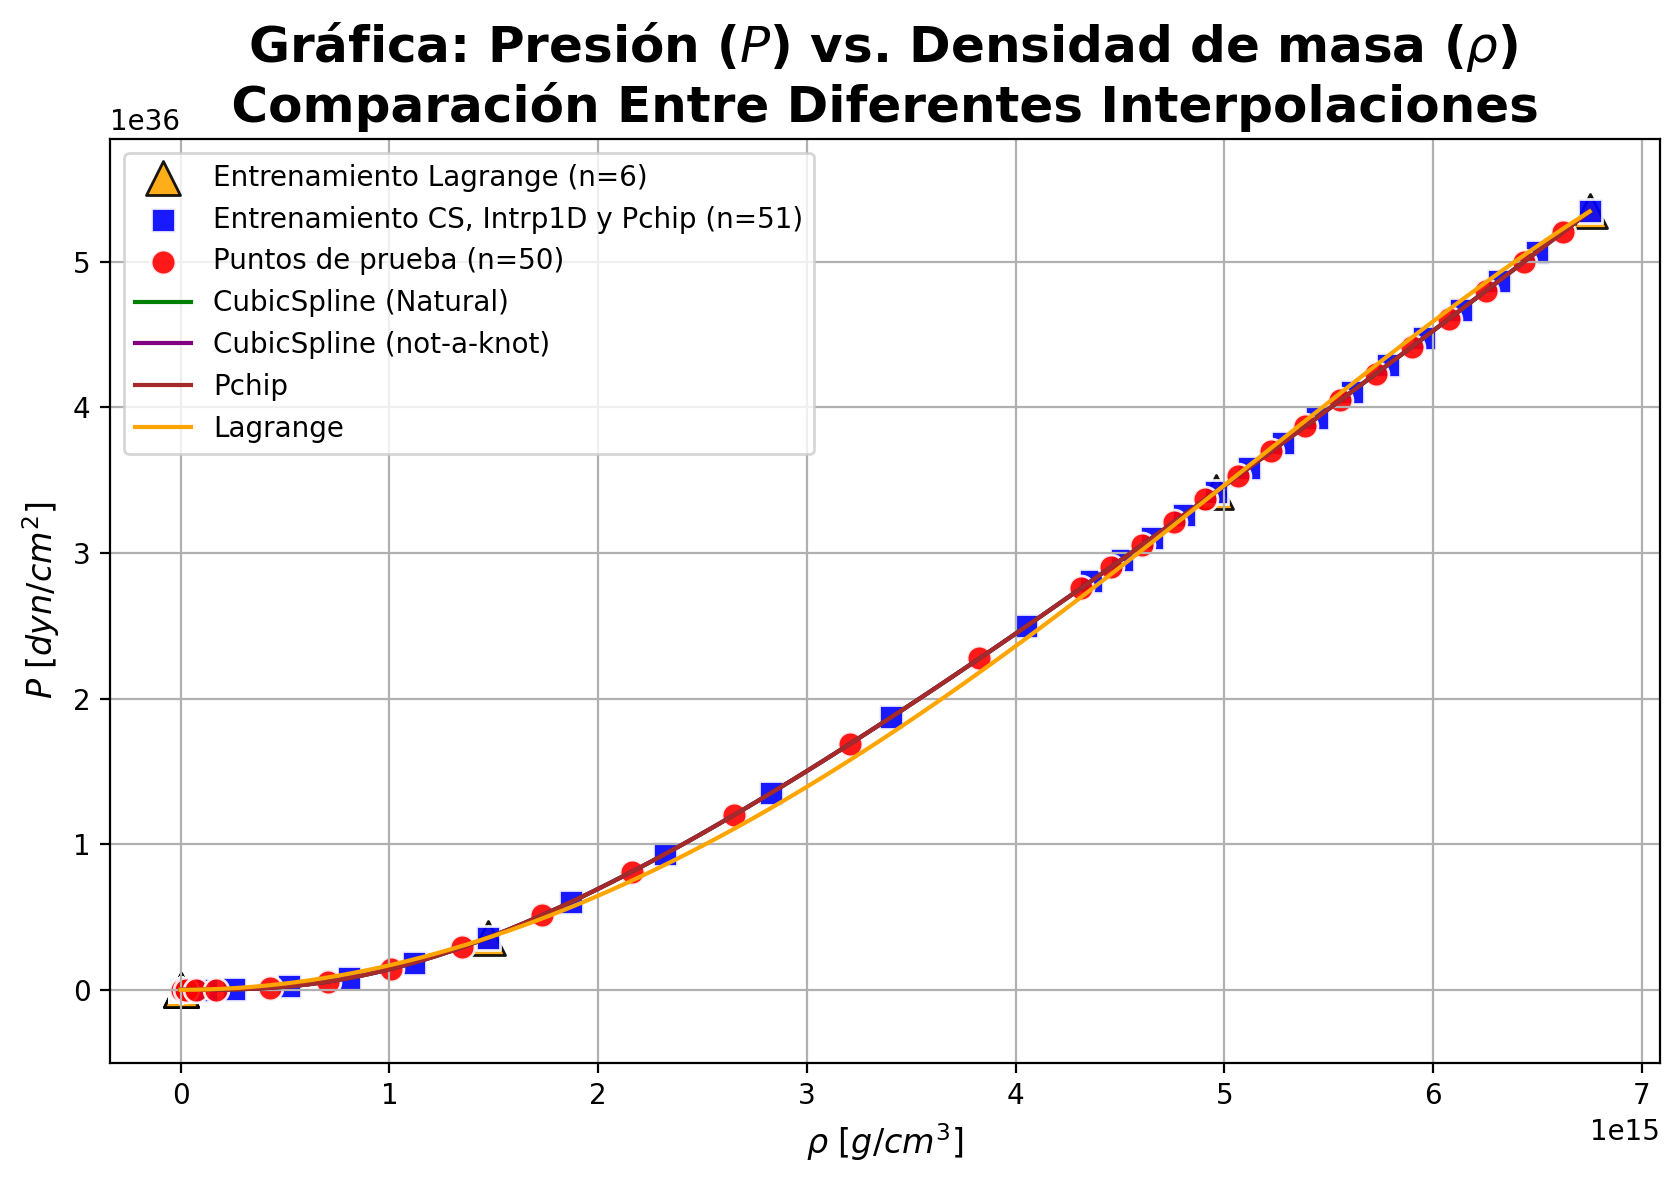

In [19]:
# ======================================================
# Gráfica: Comparación Entre Diferentes Interpolaciones
# ======================================================

plt.figure(figsize=(10,6))

# Grupos de pruba y entrenamiento
plt.scatter(XtrainL1, YtrainL1, label=f"Entrenamiento Lagrange (n={len(XtrainL1)})", facecolors="orange", edgecolors="black", marker="^", s=150, alpha=0.9)
plt.scatter(Xtrain1, Ytrain1, label=f"Entrenamiento CS, Intrp1D y Pchip (n={len(Xtrain1)})", facecolors="blue", edgecolors="white", marker="s", s=80, alpha=0.9)
plt.scatter(Xtest1, Ytest1, label=f"Puntos de prueba (n={len(Xtest1)})", facecolors="red", edgecolors="white", marker="o", s=80, alpha=0.9)

# Interpolaciones
plt.plot(X1, CubicSpline_INT(X1), label="CubicSpline (Natural)", color = "green")
plt.plot(X1, interp1d_INT(X1), label="CubicSpline (not-a-knot)", color = "purple")
plt.plot(X1, Pchip_INT(X1), label="Pchip", color = "brown")
plt.plot(X1, Lagrange_INT(X1), label="Lagrange", color = "orange")

plt.title(f"Gráfica: Presión ($P$) vs. Densidad de masa ($\\rho$) \n Comparación Entre Diferentes Interpolaciones ", fontweight="bold", fontsize = "18")
plt.xlabel("$\\rho$ $[g/cm^3]$", fontsize = "12")
plt.ylabel("$P$ $[dyn/cm^2]$", fontsize = "12")
plt.ylim(P[0] - 5e35, P[-1] + 5e35)
plt.legend()
plt.grid()
plt.show()

**Gráfica de Errores Relativos**

---

En esta parte del codigo se representa el **Error Absoluto Relativo (RAE)** para los diferentes métodos de interpolación:

- Se comparan los errores de **Lagrange, Cubic Spline, interp1d y PCHIP** en los puntos de prueba.  
- El eje $x$ corresponde a la **densidad ($\rho$)** y el eje $y$ al **error relativo** en cada punto.  
- Esta visualización permite analizar qué método ofrece una mejor aproximación y en qué regiones los errores son más significativos.  

---


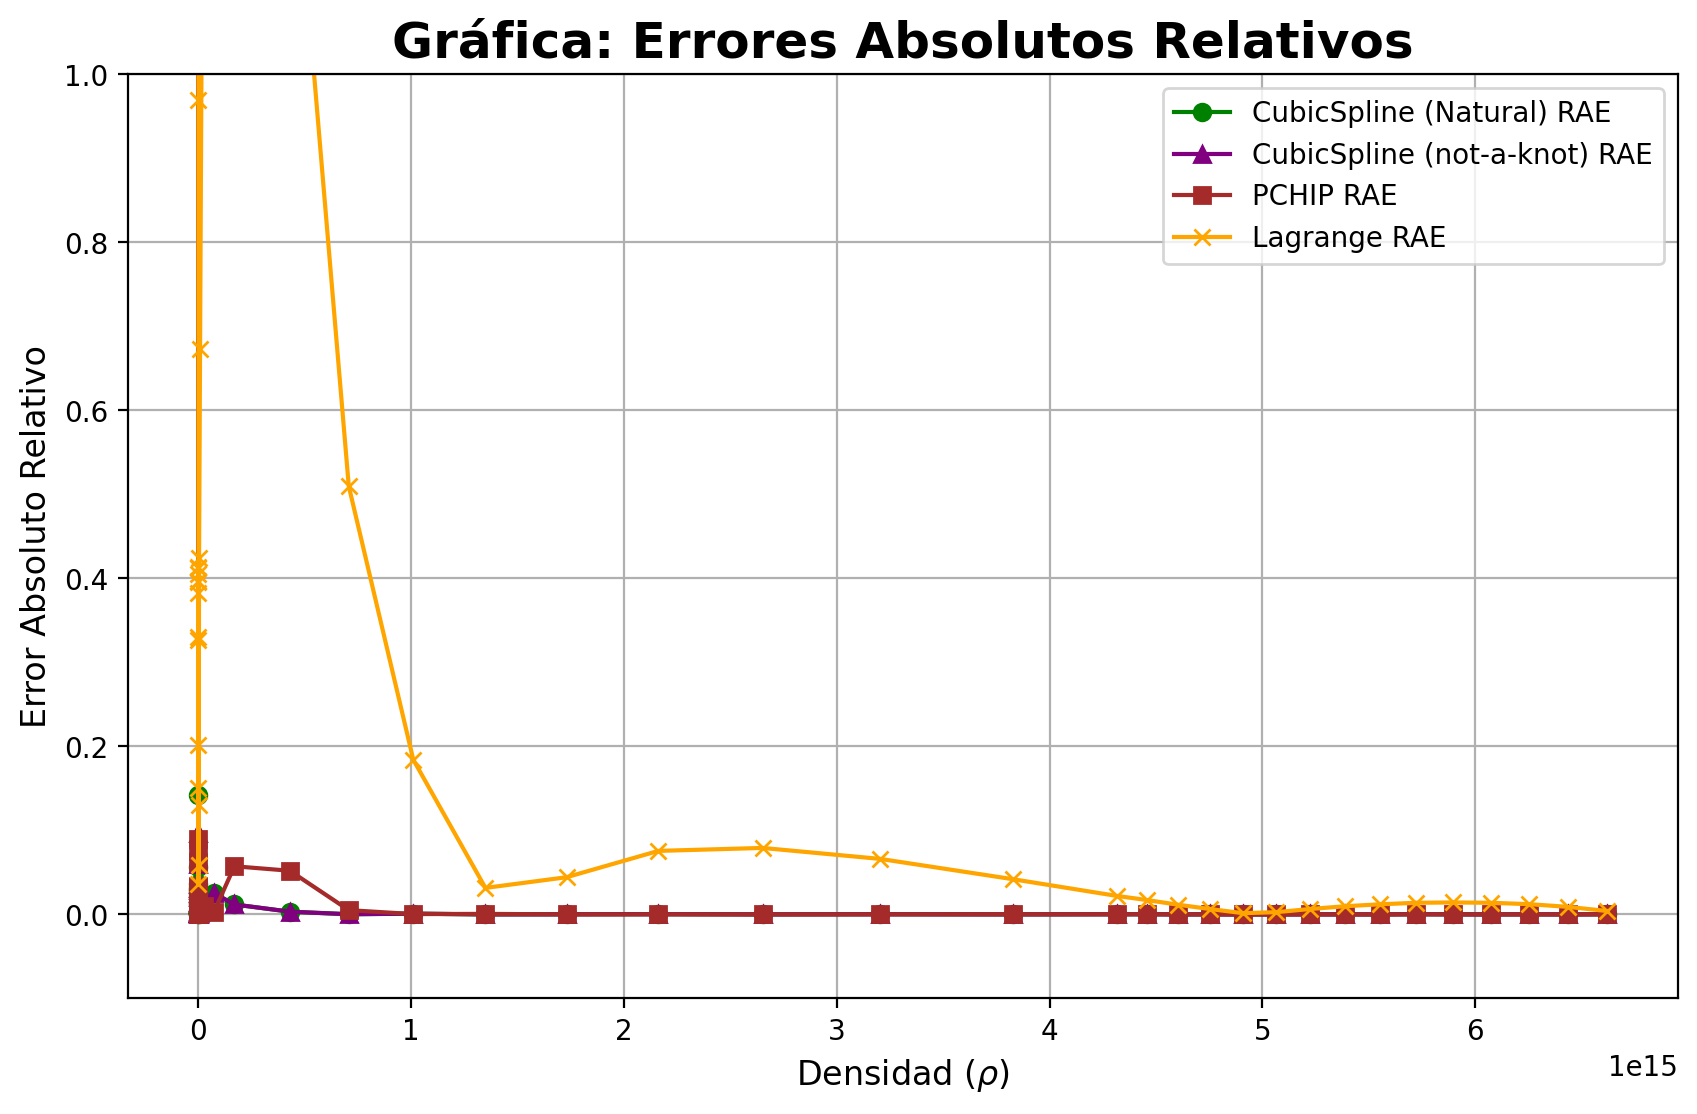

In [20]:
# ================================================
# Gráfica: Comparación de error absoluto relativo
# ================================================

plt.figure(figsize=(10,6))

# Error absoluto relativo
plt.plot(Xtest1, RAE_CubicSpline1, label="CubicSpline (Natural) RAE", marker="o", color="green", ms=6)
plt.plot(Xtest1, RAE_interp1d1, label="CubicSpline (not-a-knot) RAE", marker="^", color="purple", ms=6)
plt.plot(Xtest1, RAE_Pchip1, label="PCHIP RAE", marker="s", color="brown", ms=6)
plt.plot(Xtest1, RAE_Lagrange1, label="Lagrange RAE", marker="x", color="orange", ms=6)

plt.title("Gráfica: Errores Absolutos Relativos", fontweight="bold", fontsize=18)
plt.xlabel("Densidad ($\\rho$)", fontsize=12)
plt.ylabel("Error Absoluto Relativo", fontsize=12)

limite = 1
plt.ylim(-limite/10, limite)

plt.legend()
plt.grid()
plt.show()

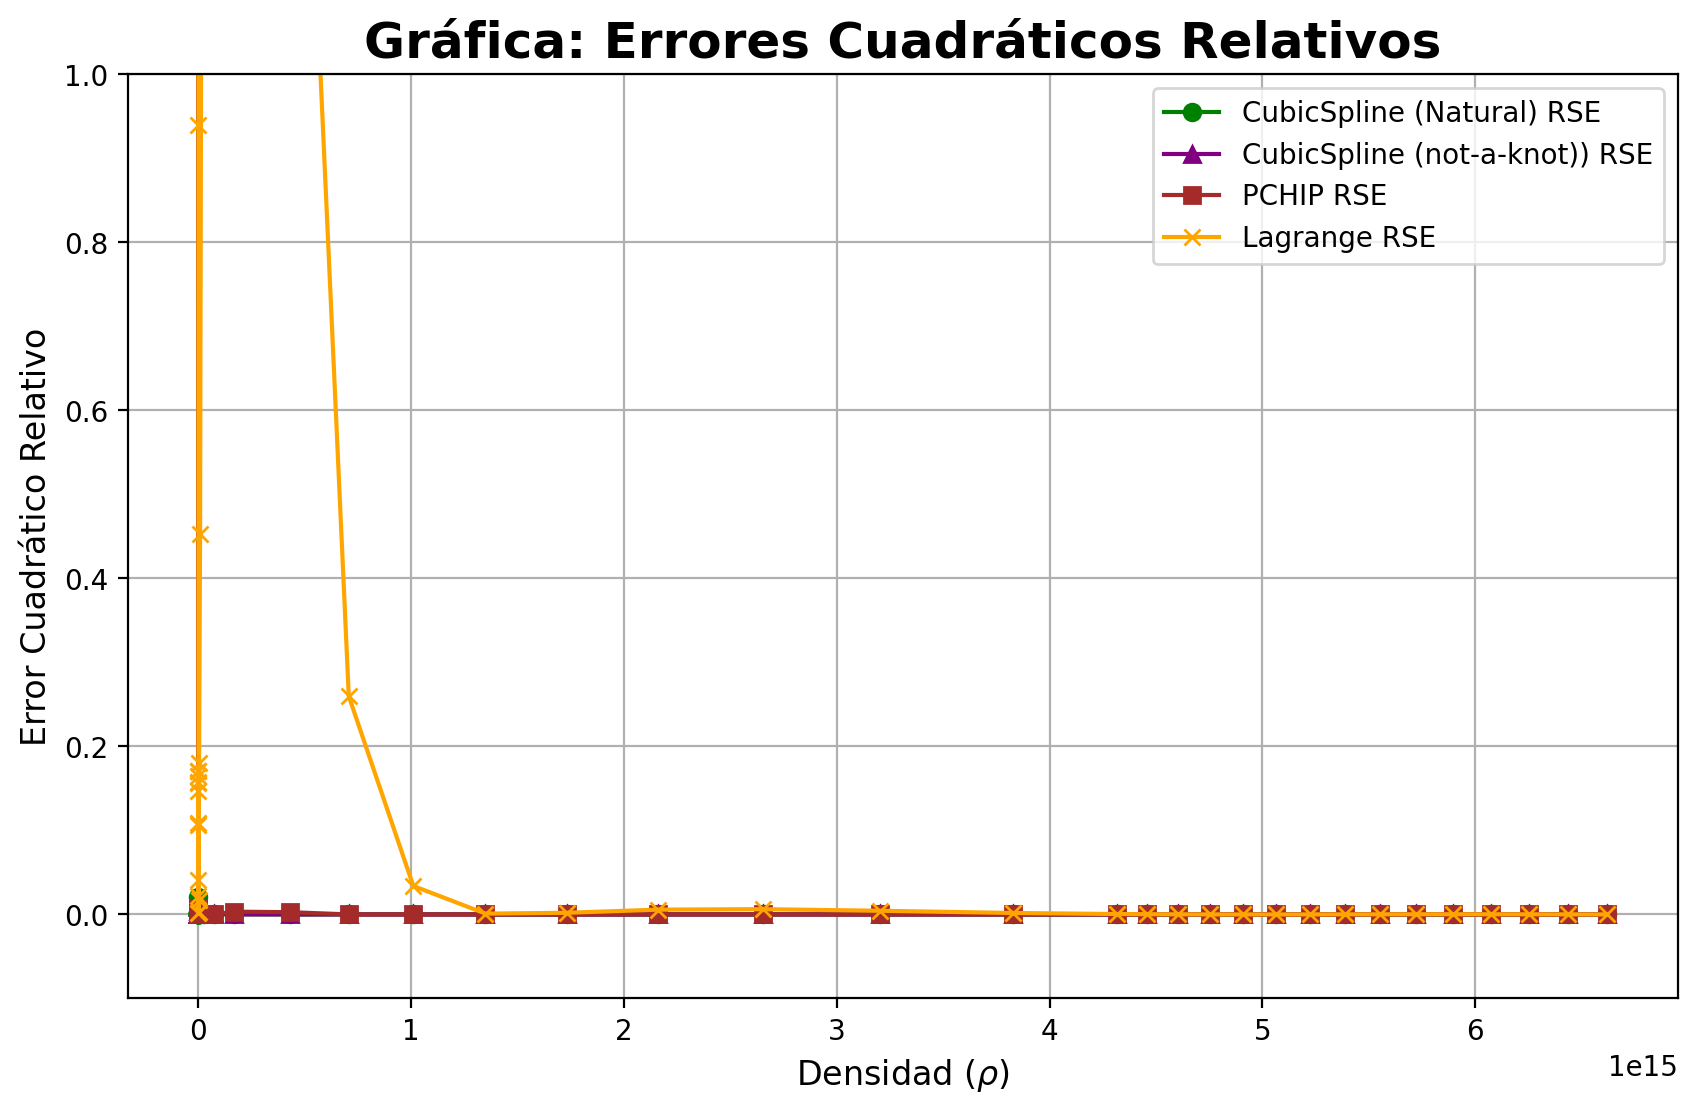

In [54]:
# ==================================================
# Gráfica: Comparación de error cuadrático relativo
# ==================================================

plt.figure(figsize=(10,6))

# Error absoluto relativo
plt.plot(Xtest1, RSE_CubicSpline1, label="CubicSpline (Natural) RSE", marker="o", color="green", ms=6)
plt.plot(Xtest1, RSE_interp1d1, label="CubicSpline (not-a-knot)) RSE", marker="^", color="purple", ms=6)
plt.plot(Xtest1, RSE_Pchip1, label="PCHIP RSE", marker="s", color="brown", ms=6)
plt.plot(Xtest1, RSE_Lagrange1, label="Lagrange RSE", marker="x", color="orange", ms=6)

plt.title("Gráfica: Errores Cuadráticos Relativos", fontweight="bold", fontsize=18)
plt.xlabel("Densidad ($\\rho$)", fontsize=12)
plt.ylabel("Error Cuadrático Relativo", fontsize=12)

limite = 1
plt.ylim(-limite/10, limite)

plt.legend()
plt.grid()
plt.show()

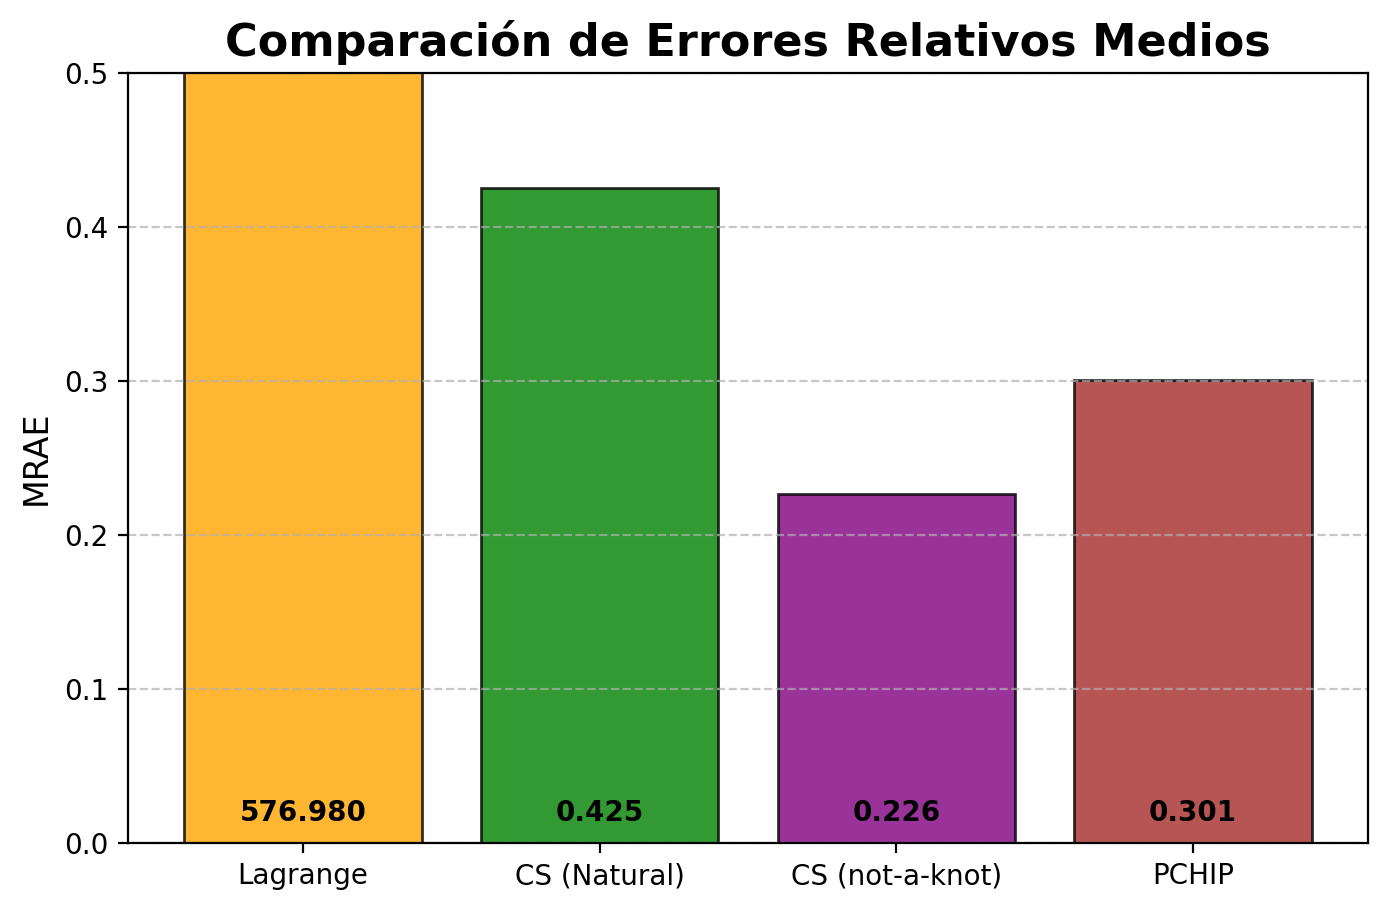

In [57]:
# Valores de MRAE
mrae_values1 = [MRAE_Lagrange1, MRAE_CubicSpline1, MRAE_interp1d1, MRAE_Pchip1]
labels1 = ["Lagrange", "CS (Natural)", "CS (not-a-knot)", "PCHIP"]


# Barplot MRAE
plt.figure(figsize=(8,5))
bars = plt.bar(labels1, mrae_values1, color=["orange", "green", "purple", "brown"], alpha=0.8, edgecolor="black")

plt.title("Comparación de Errores Relativos Medios", fontsize=16, fontweight="bold")
plt.ylabel("MRAE", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0,0.5)

# Agrregar texto
for bar, value in zip(bars, mrae_values1):
    plt.text(bar.get_x() + bar.get_width()/2, 0.01, f"{value:.3f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

plt.show()

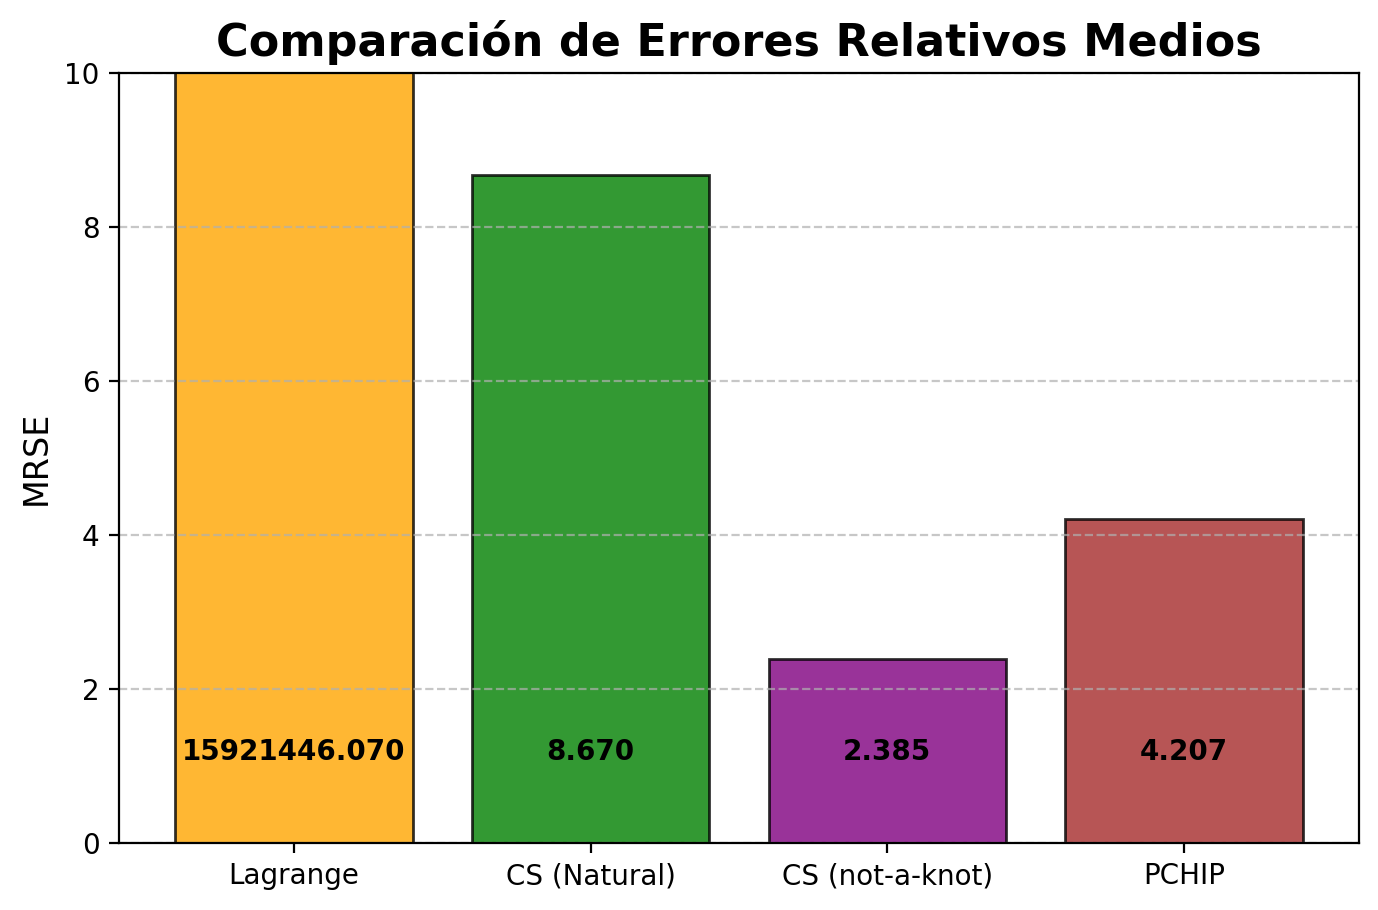

In [56]:

mrse_values1 = [MRSE_Lagrange, MRSE_CubicSpline, MRSE_interp1d, MRSE_Pchip]
labels1 = ["Lagrange", "CS (Natural)", "CS (not-a-knot)", "PCHIP"]
# Barplot MRSE
plt.figure(figsize=(8,5))
bars = plt.bar(labels1, mrse_values1, color=["orange", "green", "purple", "brown"], alpha=0.8, edgecolor="black")

plt.title("Comparación de Errores Relativos Medios", fontsize=16, fontweight="bold")
plt.ylabel("MRSE", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0,10)

# Agrregar texto
for bar, value in zip(bars, mrse_values1):
    plt.text(bar.get_x() + bar.get_width()/2, 1, f"{value:.3f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

plt.show()

## Presión ($P$) vs. Densidad numérica bariónica ($n_B$)

### Definir los puntos de entrenamiento y prueba

In [26]:
# Para CubicSpline, interp1d y PchipInterpolator
indices21 = np.linspace(0, len(nB)-1, 101, dtype=int) # 151 puntos para las interpolaciones
Xall2 = nB[indices21]
Yall2 = P[indices21]
Xtrain2 = Xall2[0::2]
Ytrain2 = Yall2[0::2]
Xtest2  = Xall2[1::2]
Ytest2  = Yall2[1::2]

# Para Lagrange
indices22 = np.linspace(0, len(nB)-1, 6, dtype=int) # 6 puntos aparte para lagrange
XtrainL2 = nB[indices22]
YtrainL2 = P[indices22]

# Resultados importantes
print(f"Para CubicSpline, interp1d y PchipInterpolator")
print(f"El tamaño del grupo de entrenamiento es de {len(Xtrain2)} puntos")
print(f"El tamaño del grupo de prueba es de {len(Xtest2)} puntos")
print()
print(f"Para Lagrange")
print(f"El tamaño del grupo de entrenamiento es de {len(XtrainL2)} puntos")
print(f"El tamaño del grupo de prueba es de {len(Xtest2)} puntos")

Para CubicSpline, interp1d y PchipInterpolator
El tamaño del grupo de entrenamiento es de 51 puntos
El tamaño del grupo de prueba es de 50 puntos

Para Lagrange
El tamaño del grupo de entrenamiento es de 6 puntos
El tamaño del grupo de prueba es de 50 puntos


### Realizar las interpolaciones para los métodos

In [28]:
INT_CubicSpline = CubicSpline(Xtrain2, Ytrain2, bc_type = "natural")            # CubicSpline
INT_interp1d = interp1d(Xtrain2, Ytrain2, kind= "cubic")   # interp1d
INT_Pchip = PchipInterpolator(Xtrain2, Ytrain2)            # PchipInterpolator
INT_Lagrange = lagrange(XtrainL2, YtrainL2)                # lagrange

X2 = np.linspace(Xtrain2[0], Xtrain2[-1],100)              # Puntos para las graficas

### Cálculos de errores (RAE, MRAE, RSE, MRSE)

In [29]:
# Relative Absolute Error (RAE)
RAE_Lagrange2 = np.abs(Ytest2 - INT_Lagrange(Xtest2)) / np.abs(Ytest2)
RAE_CubicSpline2 = np.abs(Ytest2 - INT_CubicSpline(Xtest2)) / np.abs(Ytest2)
RAE_interp1d2 = np.abs(Ytest2 - INT_interp1d(Xtest2)) / np.abs(Ytest2)
RAE_Pchip2 = np.abs(Ytest2 - INT_Pchip(Xtest2)) / np.abs(Ytest2)

# Mean Relative Absolute Error (MRAE)
MRAE_Lagrange2 = np.mean(RAE_Lagrange2)
MRAE_CubicSpline2 = np.mean(RAE_CubicSpline2)
MRAE_interp1d2 = np.mean(RAE_interp1d2)
MRAE_Pchip2 = np.mean(RAE_Pchip2)

# Relative Squared Error (RSE)
RSE_Lagrange2 = RAE_Lagrange2**2
RSE_CubicSpline2 = RAE_CubicSpline2**2
RSE_interp1d2 = RAE_interp1d2**2
RSE_Pchip2 = RAE_Pchip2**2

# Mean Relative Squared Error (MRSE)
MRSE_Lagrange2 = np.mean(RSE_Lagrange2)
MRSE_CubicSpline2 = np.mean(RSE_CubicSpline2)
MRSE_interp1d2 = np.mean(RSE_interp1d2)
MRSE_Pchip2 = np.mean(RSE_Pchip2)

In [52]:
print("\n=== Relative Absolute Error (RAE) ===")
print(f"RAE Lagrange       -> Min: {np.min(RAE_Lagrange2):.3e} | Max: {np.max(RAE_Lagrange2):.3e}")
print(f"RAE CS (Natural)   -> Min: {np.min(RAE_CubicSpline2):.3e} | Max: {np.max(RAE_CubicSpline2):.3e}")
print(f"RAE CS (not-a-knot)-> Min: {np.min(RAE_interp1d2):.3e} | Max: {np.max(RAE_interp1d2):.3e}")
print(f"RAE PCHIP          -> Min: {np.min(RAE_Pchip2):.3e} | Max: {np.max(RAE_Pchip2):.3e}")

print("\n=== Mean Relative Absolute Error (MRAE) ===")
print(f"MRAE Lagrange:        {MRAE_Lagrange2:.3e}")
print(f"MRAE CS (Natural):    {MRAE_CubicSpline2:.3e}")
print(f"MRAE CS (not-a-knot): {MRAE_interp1d2:.3e}")
print(f"MRAE PCHIP:           {MRAE_Pchip2:.3e}")

print("\n=== Relative Squared Error (RSE) ===")
print(f"RSE Lagrange       -> Min: {np.min(RSE_Lagrange2):.3e} | Max: {np.max(RSE_Lagrange2):.3e}")
print(f"RSE CS (Natural)   -> Min: {np.min(RSE_CubicSpline2):.3e} | Max: {np.max(RSE_CubicSpline2):.3e}")
print(f"RSE CS (not-a-knot)-> Min: {np.min(RSE_interp1d2):.3e} | Max: {np.max(RSE_interp1d2):.3e}")
print(f"RSE PCHIP          -> Min: {np.min(RSE_Pchip2):.3e} | Max: {np.max(RSE_Pchip2):.3e}")

print("\n=== Mean Relative Squared Error (MRSE) ===")
print(f"MRSE Lagrange:        {MRSE_Lagrange2:.3e}")
print(f"MRSE CS (Natural):    {MRSE_CubicSpline2:.3e}")
print(f"MRSE CS (not-a-knot): {MRSE_interp1d2:.3e}")
print(f"MRSE PCHIP:           {MRSE_Pchip2:.3e}")


=== Relative Absolute Error (RAE) ===
RAE Lagrange       -> Min: 5.184e-04 | Max: 2.807e+04
RAE CS (Natural)   -> Min: 1.132e-06 | Max: 2.064e+01
RAE CS (not-a-knot)-> Min: 1.132e-06 | Max: 1.083e+01
RAE PCHIP          -> Min: 1.580e-05 | Max: 1.438e+01

=== Mean Relative Absolute Error (MRAE) ===
MRAE Lagrange:        5.742e+02
MRAE CS (Natural):    4.217e-01
MRAE CS (not-a-knot): 2.245e-01
MRAE PCHIP:           2.983e-01

=== Relative Squared Error (RSE) ===
RSE Lagrange       -> Min: 2.688e-07 | Max: 7.877e+08
RSE CS (Natural)   -> Min: 1.281e-12 | Max: 4.261e+02
RSE CS (not-a-knot)-> Min: 1.281e-12 | Max: 1.173e+02
RSE PCHIP          -> Min: 2.495e-10 | Max: 2.068e+02

=== Mean Relative Squared Error (MRSE) ===
MRSE Lagrange:        1.576e+07
MRSE CS (Natural):    8.523e+00
MRSE CS (not-a-knot): 2.346e+00
MRSE PCHIP:           4.136e+00


### Gráficas

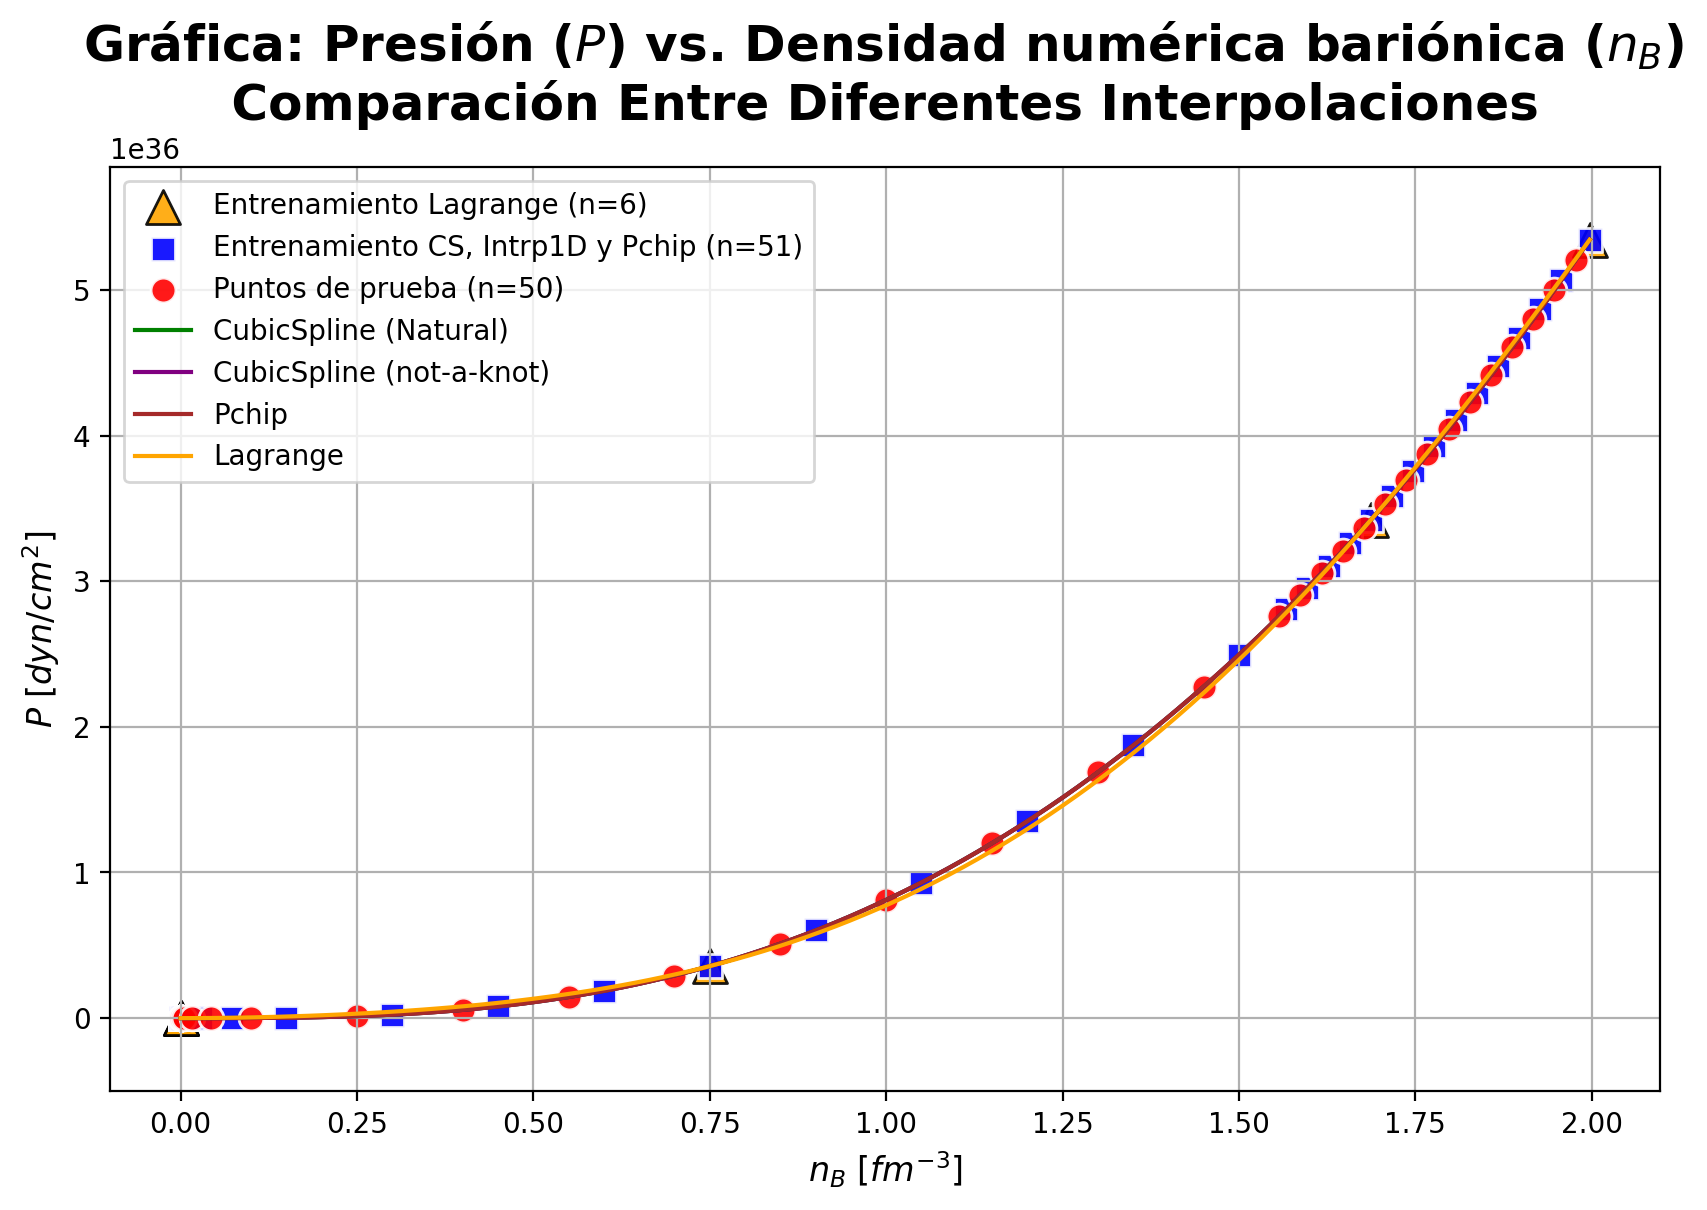

In [32]:
# ======================================================
# Gráfica: Comparación Entre Diferentes Interpolaciones
# ======================================================

plt.figure(figsize=(10,6))

# Grupos de pruba y entrenamiento
plt.scatter(XtrainL2, YtrainL2, label=f"Entrenamiento Lagrange (n={len(XtrainL2)})", facecolors="orange", edgecolors="black", marker="^", s=150, alpha=0.9)
plt.scatter(Xtrain2, Ytrain2, label=f"Entrenamiento CS, Intrp1D y Pchip (n={len(Xtrain2)})", facecolors="blue", edgecolors="white", marker="s", s=80, alpha=0.9)
plt.scatter(Xtest2, Ytest2, label=f"Puntos de prueba (n={len(Xtest2)})", facecolors="red", edgecolors="white", marker="o", s=80, alpha=0.9)

# Interpolaciones
plt.plot(X2, INT_CubicSpline(X2), label="CubicSpline (Natural)", color = "green")
plt.plot(X2, INT_interp1d(X2), label="CubicSpline (not-a-knot)", color = "purple")
plt.plot(X2, INT_Pchip(X2), label="Pchip", color = "brown")
plt.plot(X2, INT_Lagrange(X2), label="Lagrange", color = "orange")

plt.title(f"Gráfica: Presión ($P$) vs. Densidad numérica bariónica ($n_B$) \n Comparación Entre Diferentes Interpolaciones ", fontweight="bold", fontsize = "18")
plt.xlabel("$n_B$ $[fm^{-3}]$", fontsize = "12")
plt.ylabel("$P$ $[dyn/cm^2]$", fontsize = "12")
plt.ylim(P[0] - 5e35, P[-1] + 5e35)
plt.legend()
plt.grid()
plt.show()

**Gráfica de Errores Relativos**

---

En esta parte del codigo se representa el **Error Absoluto Relativo (RAE)** para los diferentes métodos de interpolación:

- Se comparan los errores de **Lagrange, Cubic Spline, interp1d y PCHIP** en los puntos de prueba.  
- El eje $x$ corresponde a la **densidad numérica bariónica ($n_B$)** y el eje $y$ al **error relativo** en cada punto.

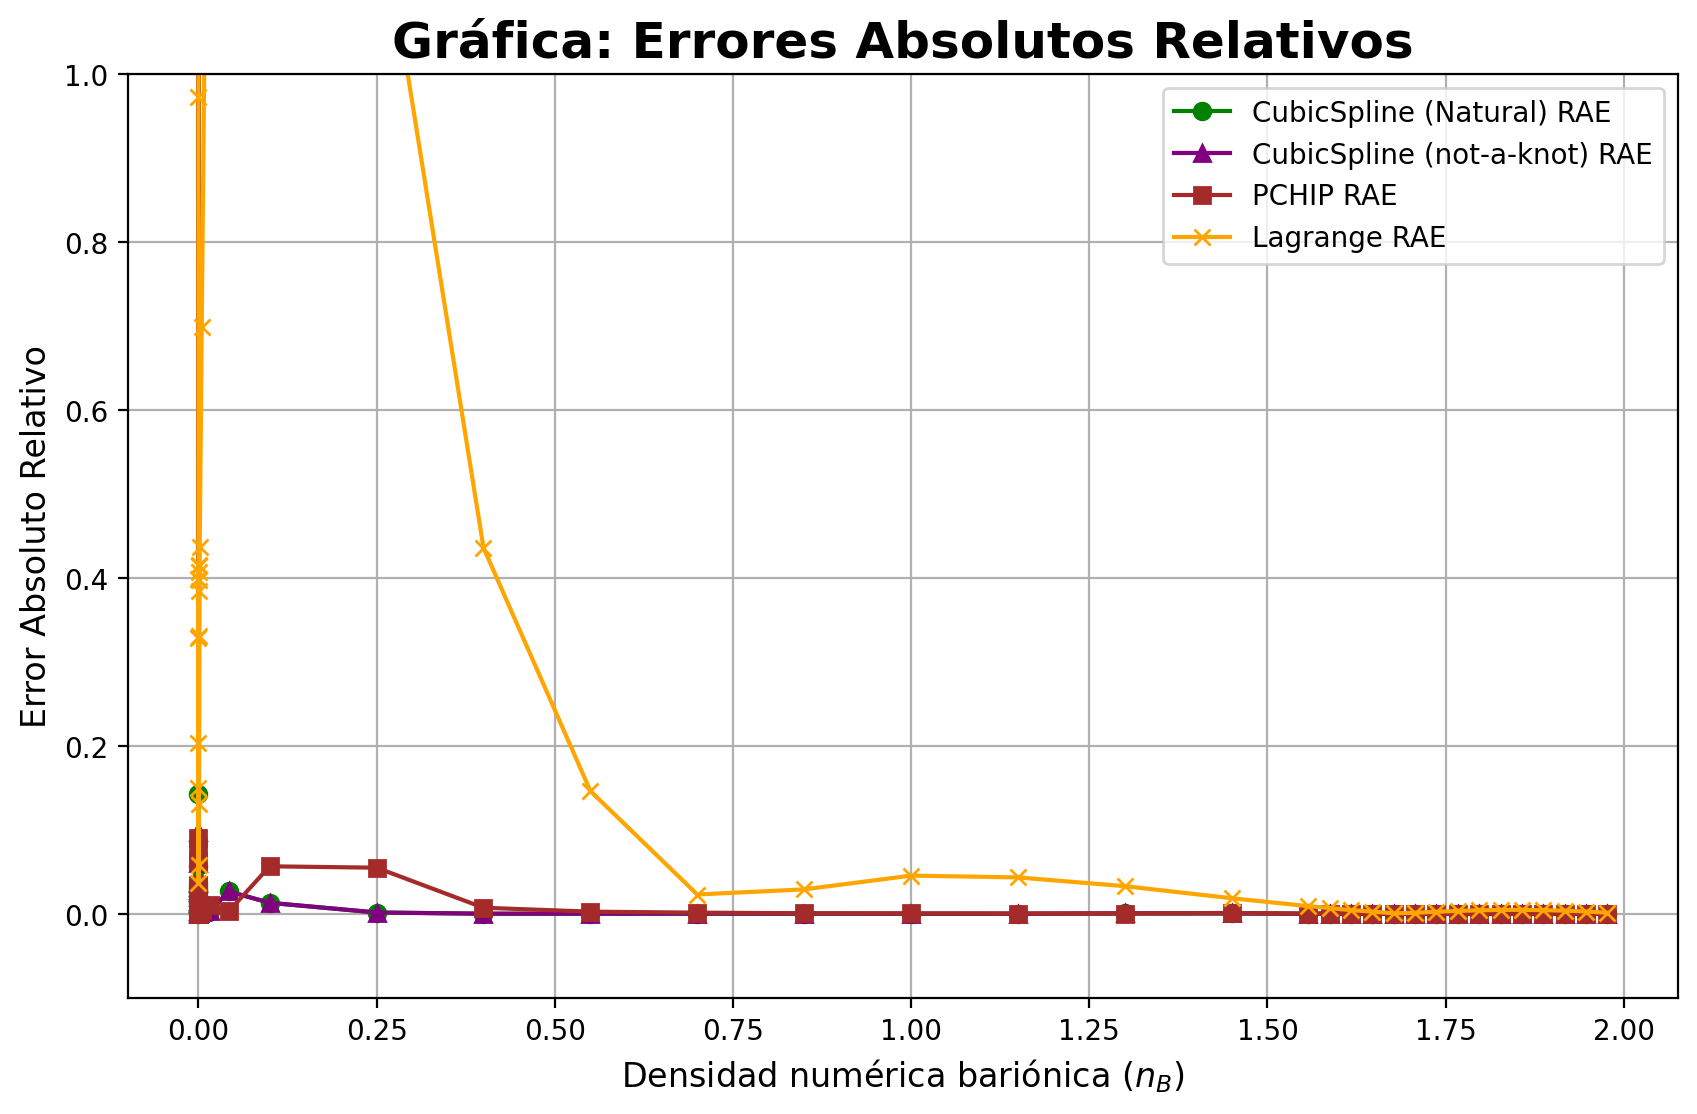

In [33]:
# ================================================
# Gráfica: Comparación de error absoluto relativo
# ================================================

plt.figure(figsize=(10,6))

# Error absoluto relativo
plt.plot(Xtest2, RAE_CubicSpline2, label="CubicSpline (Natural) RAE", marker="o", color="green", ms=6)
plt.plot(Xtest2, RAE_interp1d2, label="CubicSpline (not-a-knot) RAE", marker="^", color="purple", ms=6)
plt.plot(Xtest2, RAE_Pchip2, label="PCHIP RAE", marker="s", color="brown", ms=6)
plt.plot(Xtest2, RAE_Lagrange2, label="Lagrange RAE", marker="x", color="orange", ms=6)

plt.title("Gráfica: Errores Absolutos Relativos", fontweight="bold", fontsize=18)
plt.xlabel("Densidad numérica bariónica ($n_B$)", fontsize=12)
plt.ylabel("Error Absoluto Relativo", fontsize=12)

limite = 1
plt.ylim(-limite/10, limite)

plt.legend()
plt.grid()
plt.show()

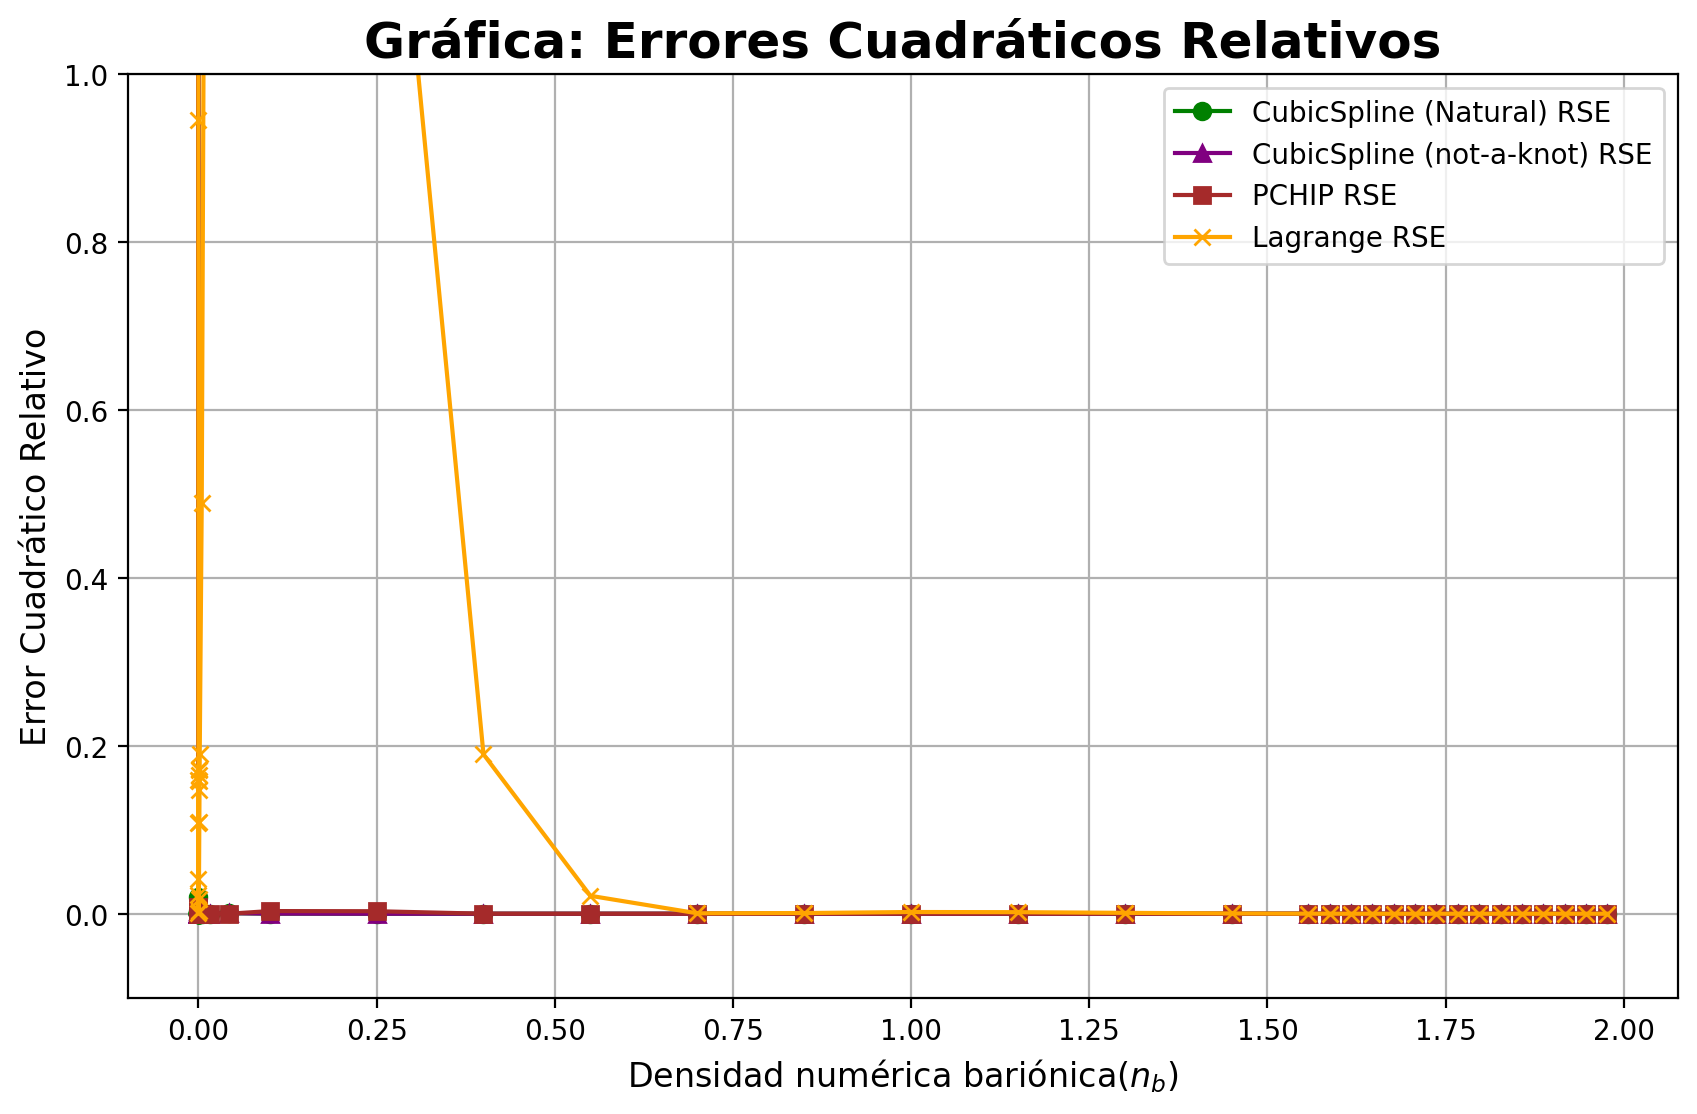

In [53]:
# ==================================================
# Gráfica: Comparación de error cuadrático relativo
# ==================================================

plt.figure(figsize=(10,6))

# Error absoluto relativo
plt.plot(Xtest2, RSE_CubicSpline2, label="CubicSpline (Natural) RSE", marker="o", color="green", ms=6)
plt.plot(Xtest2, RSE_interp1d2, label="CubicSpline (not-a-knot) RSE", marker="^", color="purple", ms=6)
plt.plot(Xtest2, RSE_Pchip2, label="PCHIP RSE", marker="s", color="brown", ms=6)
plt.plot(Xtest2, RSE_Lagrange2, label="Lagrange RSE", marker="x", color="orange", ms=6)

plt.title("Gráfica: Errores Cuadráticos Relativos", fontweight="bold", fontsize=18)
plt.xlabel("Densidad numérica bariónica($n_b$)", fontsize=12)
plt.ylabel("Error Cuadrático Relativo", fontsize=12)

limite = 1
plt.ylim(-limite/10, limite)

plt.legend()
plt.grid()
plt.show()

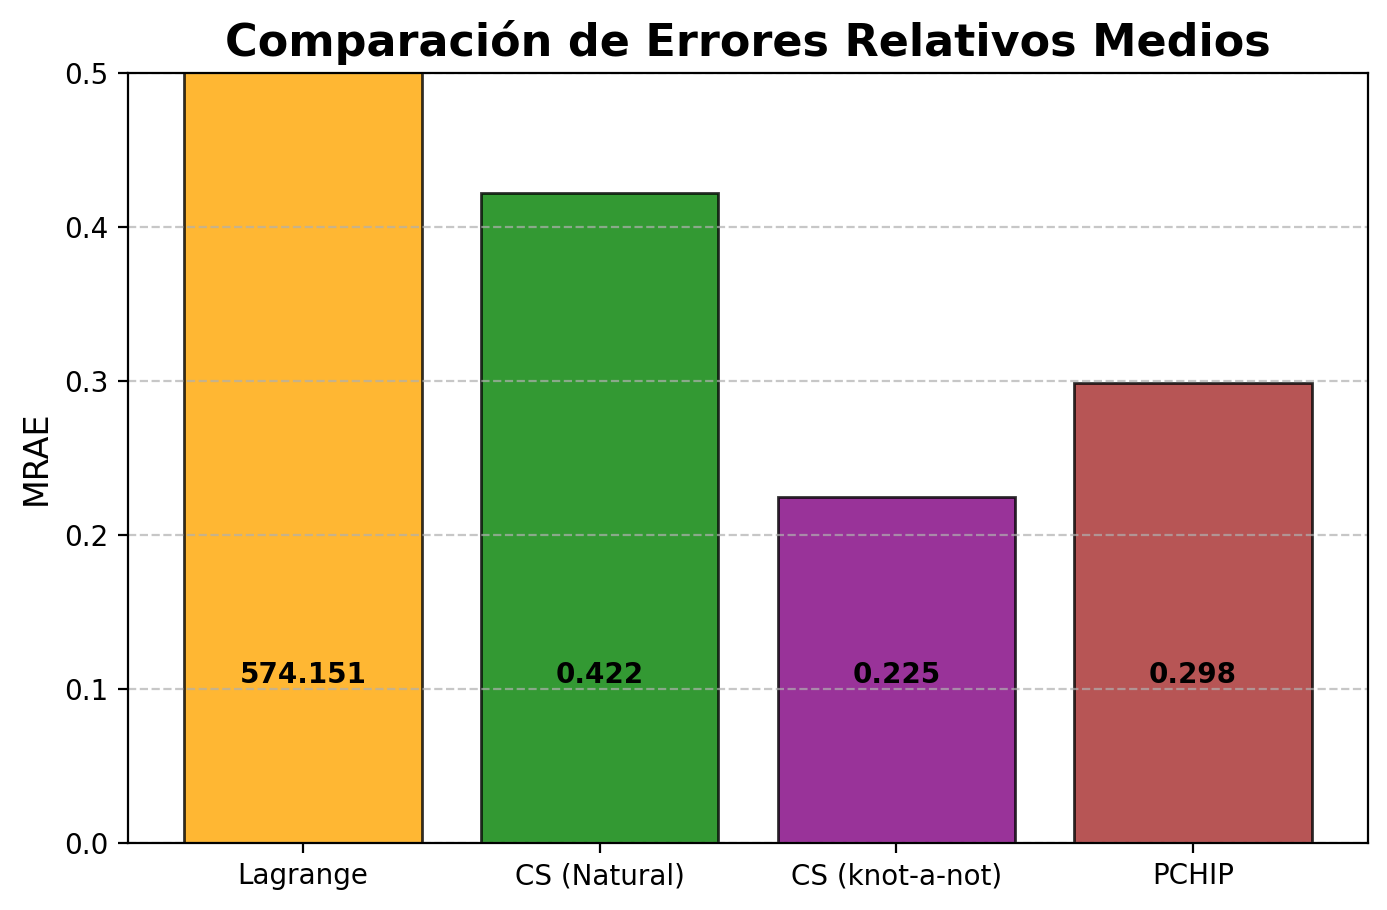

In [44]:
# Valores de MRAE
mrae_values2 = [MRAE_Lagrange2, MRAE_CubicSpline2, MRAE_interp1d2, MRAE_Pchip2]
labels2 = ["Lagrange", "CS (Natural)", "CS (knot-a-not)", "PCHIP"]

# Barplot MRAE
plt.figure(figsize=(8,5))
bars = plt.bar(labels2, mrae_values2, color=["orange", "green", "purple", "brown"], alpha=0.8, edgecolor="black")

plt.title("Comparación de Errores Relativos Medios", fontsize=16, fontweight="bold")
plt.ylabel("MRAE", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0,0.5)

# Agrregar texto
for bar, value in zip(bars, mrae_values2):
    plt.text(bar.get_x() + bar.get_width()/2, 0.1, f"{value:.3f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

plt.show()

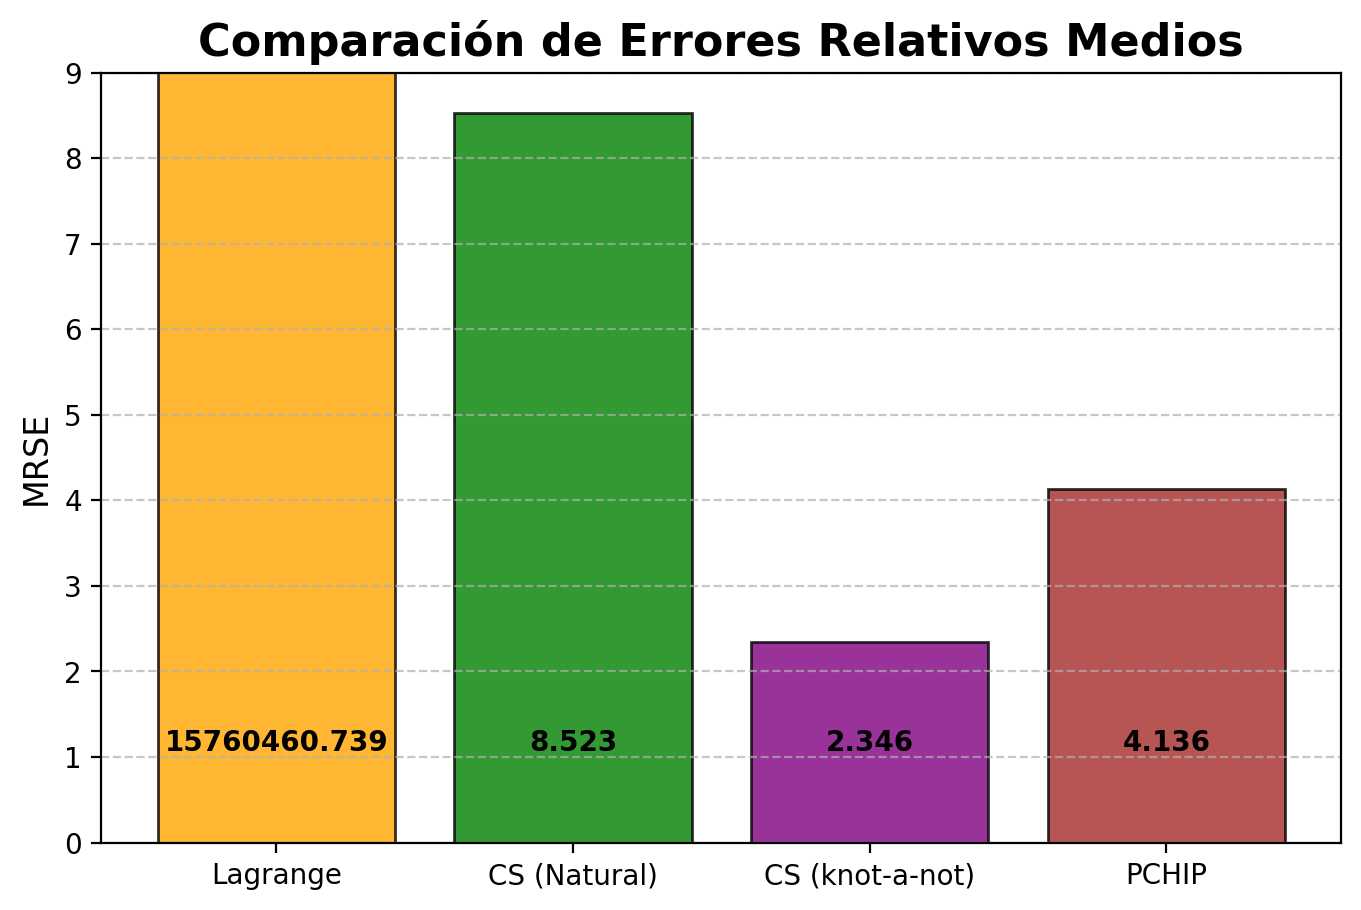

In [55]:
# Valores de MRAE
mrse_values2 = [MRSE_Lagrange2, MRSE_CubicSpline2, MRSE_interp1d2, MRSE_Pchip2]
label2 = ["Lagrange", "CS (Natural)", "CS (not-a-knot)", "PCHIP"]

# Barplot MRAE
plt.figure(figsize=(8,5))
bars = plt.bar(labels2, mrse_values2, color=["orange", "green", "purple", "brown"], alpha=0.8, edgecolor="black")

plt.title("Comparación de Errores Relativos Medios", fontsize=16, fontweight="bold")
plt.ylabel("MRSE", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0,9)

# Agrregar texto
for bar, value in zip(bars, mrse_values2):
    plt.text(bar.get_x() + bar.get_width()/2, 1, f"{value:.3f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

plt.show()